In [1]:
from scipy.linalg import expm, sinm, cosm
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import *
from IPython.display import display

### State dynamics
$\dot{\phi} = \omega_1 + tan\theta(\omega_2 sin\phi + \omega_3 cos\phi)$

$\dot{\theta} = \omega_2 cos\phi − \omega_3 sin\phi$

$\dot{\psi} = sec\theta(\omega_2 sin\phi + \omega_3 cos\phi)$

$\dot{\omega_1} = \frac{I_{yy} − I_{zz}}{I_{xx}}\omega_2\omega_3 + M_1/I_{xx}$

$\dot{\omega_2} = \frac{I_{zz} − I_{xx}}{I_{yy}}\omega_1\omega_3 + M_2/I_{yy}$

$\dot{\omega_3} = \frac{I_{xx} − I_{yy}}{I_{zz}}\omega_1\omega_2 + M_3/I_{zz}$

### Measurement model

$ y = 
\begin{bmatrix}
R^Tm_I \\
R^Ta_I \\
\omega
\end{bmatrix} 
+ \nu
$
where m_I and a_I are system dependent constants.

### Control Law

$ M = \omega \times I\omega − Ik_p\omega $ 

$k_p = 0.5I_{3×3} $

## Kalman Filter equations

#### Model
$\dot{x} = f(x,u) + G\omega , \omega ~ N(0,Q)$

$y_k = h(x_k) + \nu_k , \nu_k ~ N(0,R_k)$

#### Propogate
$F_k = e^{A\delta t}, with\; A = \frac{\partial f}{\partial x}$

$B_k = [\int_0^{\delta t}d\tau e^{A\tau}B], with\; B = \frac{\partial f}{\partial u}$

$x_k^- = F_{k-1}x_{k-1}^+ + B_{k-1}u_{k-1}$

$P_{k}^- =F_{k-1}P_{k-1}^+F_{k-1}^T + \delta tGQG^T$

#### Kalman Gain
$H_k = \frac{\partial h}{\partial x}$

$K_k = P_k^-H_k^T[H_kP_k^-H_k^T + R^T]^{-1}$

#### Update
$x_k^+ = x_k^- + K_k[y_k - h(x_k^-)]$

$P_K^+ = [I - K_kH_k]P_k^-$

In [6]:
phi, theta, psi, w1, w2, w3, Ix, Iy, Iz, RT, mI, aI, w, m_x, m_y, m_z, a_x, a_y, a_z = symbols('phi theta psi omega1 omega2 omega3 I_xx I_yy I_zz (R)^T m_I a_I omega m_x m_y m_z a_x a_y a_z')

J = Matrix([w1 + tan(theta)*(w2*sin(phi) + w3*cos(phi)), 
            w2*cos(phi) - w3*sin(phi), 
            sec(theta)*(w2*sin(phi) + w3*cos(phi)),
            ((Iy-Iz)/Ix)*w2*w3,
            ((Iz-Ix)/Iy)*w3*w1,
            ((Ix-Iy)/Iz)*w1*w2,]).jacobian([phi, theta, psi, w1, w2, w3])

print("Jacobian matrix of state transition function f is given below." )
display(J)

print("The transpose of rotation matrix would be:")
R_x = Matrix([[1,        0,                  0],
              [0,        cos(phi), -sin(phi)],
              [0,        sin(phi),  cos(phi)]])

R_y = Matrix([[cos(theta),    0,  sin(theta)],
              [0,             1,           0],
              [-sin(theta),   0,  cos(theta)]])

R_z = Matrix([[cos(psi),    -sin(psi),    0],
              [sin(psi),    cos(psi),     0],
              [0,              0,         1]])

R = R_z*(R_y*R_x )

RT = Transpose(R)
display(RT)
#RT = MatrixSymbol("RT", 3, 3)
mI = Matrix([[m_x],[m_y],[m_z]])
aI = Matrix([[a_x],[a_y],[a_z]])
w = Matrix([[w1],[w2],[w3]])

print("And so, the measurement matrix would be:")
y = Matrix([RT*mI,
            RT*aI,
            w])
display(y)

print("Jacobian of this matrix is :")
Y = y.jacobian([phi, theta, psi, w1, w2, w3])
display(Y)

Jacobian matrix of state transition function f is given below.


Matrix([
[(omega2*cos(phi) - omega3*sin(phi))*tan(theta),   (omega2*sin(phi) + omega3*cos(phi))*(tan(theta)**2 + 1), 0,                          1,       sin(phi)*tan(theta),        cos(phi)*tan(theta)],
[            -omega2*sin(phi) - omega3*cos(phi),                                                         0, 0,                          0,                  cos(phi),                  -sin(phi)],
[(omega2*cos(phi) - omega3*sin(phi))*sec(theta), (omega2*sin(phi) + omega3*cos(phi))*tan(theta)*sec(theta), 0,                          0,       sin(phi)*sec(theta),        cos(phi)*sec(theta)],
[                                             0,                                                         0, 0,                          0, omega3*(I_yy - I_zz)/I_xx,  omega2*(I_yy - I_zz)/I_xx],
[                                             0,                                                         0, 0, omega3*(-I_xx + I_zz)/I_yy,                         0, omega1*(-I_xx + I_zz)/I_yy],
[               

The transpose of rotation matrix would be:


Matrix([
[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi),  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)],
[sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)],
[        -sin(theta),                              sin(phi)*cos(theta),                               cos(phi)*cos(theta)]]).T

And so, the measurement matrix would be:


Matrix([
[                                                                        m_x*cos(psi)*cos(theta) + m_y*sin(psi)*cos(theta) - m_z*sin(theta)],
[ m_x*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + m_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + m_z*sin(phi)*cos(theta)],
[m_x*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)) + m_y*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)) + m_z*cos(phi)*cos(theta)],
[                                                                        a_x*cos(psi)*cos(theta) + a_y*sin(psi)*cos(theta) - a_z*sin(theta)],
[ a_x*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + a_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + a_z*sin(phi)*cos(theta)],
[a_x*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)) + a_y*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)) + a_z*cos(phi)*cos(theta)],
[                                                                                                                                    omega1

Jacobian of this matrix is :


Matrix([
[                                                                                                                                          0,                           -m_x*sin(theta)*cos(psi) - m_y*sin(psi)*sin(theta) - m_z*cos(theta),                                                               -m_x*sin(psi)*cos(theta) + m_y*cos(psi)*cos(theta), 0, 0, 0],
[ m_x*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)) + m_y*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)) + m_z*cos(phi)*cos(theta), m_x*sin(phi)*cos(psi)*cos(theta) + m_y*sin(phi)*sin(psi)*cos(theta) - m_z*sin(phi)*sin(theta), m_x*(-sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi)) + m_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)), 0, 0, 0],
[m_x*(-sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi)) + m_y*(-sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi)) - m_z*sin(phi)*cos(theta), m_x*cos(phi)*cos(psi)*cos(theta) + m_y*sin(psi)*cos(phi)*cos(theta) - m_z*sin(theta)*cos(phi),  m_x*(sin(phi)*cos(psi) - sin(ps

In [21]:
class KalmanFilter(object):
    
    def __init__(self, DT, SIGMA_MAG_M, SIGMA_ACC_M, SIGMA_W_M, SIGMA_SD, INIT_COV, m_A, m_B, v_X_0, mx, my, mz, ax, ay, az):
 
        self.DT = DT
        self.mx = mx
        self.my = my
        self.mz = mz
        self.ax = ax
        self.ay = ay
        self.az = az
        self.m_A = m_A
        self.m_B = m_B
        
        self.m_G = np.matrix([[1, 0, 0, 0, 0, 0],
                              [0, 1, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 1]])
        
        self.m_Q = (SIGMA_SD**2)*np.matrix([[1, 0, 0, 0, 0, 0],
                              [0, 1, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 1]])
        
        self.m_I = np.matrix([[1, 0, 0, 0, 0, 0],            
                            [0, 1, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0],            
                            [0, 0, 0, 1, 0, 0],
                            [0, 0, 0, 0, 1, 0],            
                            [0, 0, 0, 0, 0, 1]])

        self.m_R = np.matrix([[SIGMA_MAG_M**2, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, SIGMA_MAG_M**2, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, SIGMA_MAG_M**2, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, SIGMA_ACC_M**2, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, SIGMA_ACC_M**2, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, SIGMA_ACC_M**2, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, SIGMA_W_M**2, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, SIGMA_W_M**2, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, SIGMA_W_M**2]])    
        
        #initial state and error
        self.v_X = v_X_0
        self.m_P = INIT_COV*np.matrix([[1, 0, 0, 0, 0, 0],
                                  [0, 1, 0, 0, 0, 0],
                                  [0, 0, 1, 0, 0, 0],
                                  [0, 0, 0, 1, 0, 0],
                                  [0, 0, 0, 0, 1, 0],
                                  [0, 0, 0, 0, 0, 1]])
       
        self.zeroc = np.zeros([6, 12])
        self.zero6 = np.zeros([6, 6])
        self.Ih = np.concatenate((self.m_I, self.zero6), axis=1)
        self.Il = np.concatenate((self.zero6, self.m_I), axis=0)
        
        #state dynamics
        phi, theta, psi, w1, w2, w3, self.I_x, self.I_y, self.I_z, RT, mI, aI, w, self.m_x, self.m_y, self.m_z, self.a_x, self.a_y, self.a_z = symbols('phi theta psi omega1 omega2 omega3 I_xx I_yy I_zz (R)^T m_I a_I omega m_x m_y m_z a_x a_y a_z')

        self.J = Matrix([w1 + tan(theta)*(w2*sin(phi) + w3*cos(phi)), 
                        w2*cos(phi) - w3*sin(phi), 
                        sec(theta)*(w2*sin(phi) + w3*cos(phi)),
                        ((self.I_y-self.I_z)/self.I_x)*w2*w3,
                        ((self.I_z-self.I_x)/self.I_y)*w3*w1,
                        ((self.I_x-self.I_y)/self.I_z)*w1*w2,]).jacobian([phi, theta, psi, w1, w2, w3])

        #measurement model
        R_x = Matrix([[1,        0,                  0],
                      [0,        cos(phi), -sin(phi)],
                      [0,        sin(phi),  cos(phi)]])

        R_y = Matrix([[cos(theta),    0,  sin(theta)],
                      [0,                  1,      0],
                      [-sin(theta),   0,  cos(theta)]])

        R_z = Matrix([[cos(psi),    -sin(psi),    0],
                      [sin(psi),    cos(psi),     0],
                      [0,              0,         1]])

        R = R_z*(R_y*R_x)
        RT = Transpose(R)
        mI = Matrix([[self.m_x],[self.m_y],[self.m_z]])
        aI = Matrix([[self.a_x],[self.a_y],[self.a_z]])
        w = Matrix([[w1],[w2],[w3]])
        self.y = Matrix([RT*mI,
                         RT*aI,
                         w])
        self.m_Hsym = self.y.jacobian([phi, theta, psi, w1, w2, w3])
    
    def kf_propogate(self, v_U):
        
        Ix = 0.01
        Iy = 0.01
        Iz = 0.02
        self.m_A = np.array(self.J.subs({phi:self.v_X[0,0], theta:self.v_X[1,0], psi:self.v_X[2,0], w1:self.v_X[3,0], w2:self.v_X[4,0], w3:self.v_X[5,0], self.m_x:self.mx, self.m_y:self.my, self.m_z:self.mz, self.a_x:self.ax, self.a_y:self.ay, self.a_z:self.az, self.I_x:Ix, self.I_y:Iy, self.I_z:Iz})).astype(np.float64)    
        
        #discretizing continuous time system to X(n+1) = phi*X(n) + tau*U(n)
        #phi = e^(A*dt)
        self.m_phi = expm(self.DT*self.m_A)
        #tau = (phi - I)(A^-1)B, if A is singular, we apply a different formula
        if np.linalg.det(self.m_A) == 0:
            A_bar = np.concatenate((np.concatenate((self.m_A,self.m_I), axis=1),self.zeroc), axis=0)
            exp_A_bar = expm(self.DT*A_bar)
            self.m_tau = self.Ih*exp_A_bar*self.Il
        else:
            self.m_tau = (self.m_phi - self.m_I)*(np.linalg.inv(self.m_A))*self.m_I
        #tau_d is the matrix for state disturbances
        self.m_tau_d = self.m_tau*self.m_B
    
        #prediciting state and covariance of error in state from model parameters
        self.v_X = np.dot(self.m_phi, self.v_X) + np.dot(self.m_tau, v_U)
        self.m_P = np.dot(np.dot(self.m_phi, self.m_P), self.m_phi.T) + self.DT*np.dot(np.dot(self.m_tau_d, self.m_Q), self.m_tau_d.T)

        return self.v_X
    
    def kf_update(self, v_y_m, mx, my, mz, ax, ay, az):
        
        self.m_H = np.array(self.m_Hsym.subs({phi:self.v_X[0,0], theta:self.v_X[1,0], psi:self.v_X[2,0], w1:self.v_X[3,0], w2:self.v_X[4,0], w3:self.v_X[5,0], self.m_x:mx, self.m_y:my, self.m_z:mz, self.a_x:ax, self.a_y:ay, self.a_z:az})).astype(np.float64)

        #predicted output
        v_yp = np.matrix(self.y.subs({phi:self.v_X[0,0], theta:self.v_X[1,0], psi:self.v_X[2,0], w1:self.v_X[3,0], w2:self.v_X[4,0], w3:self.v_X[5,0], self.m_x:mx, self.m_y:my, self.m_z:mz, self.a_x:ax, self.a_y:ay, self.a_z:az})).astype(np.float64)
        
        #S = CPC^T + R
        m_S = np.dot(self.m_H, np.dot(self.m_P, self.m_H.T)) + self.m_R

        #updating Kalman Gain
        m_K = np.dot(np.dot(self.m_P, self.m_H.T), np.linalg.inv(m_S))
        
        #updating state
        self.v_X = self.v_X + np.dot(m_K, (v_y_m - v_yp))
        
        #updating error
        I = np.eye(self.m_H.shape[1])
        self.m_P = (I - (m_K * self.m_H)) * self.m_P

    def real_ode(self, v_X, r_t):

        Ix = 0.01
        Iy = 0.01
        Iz = 0.02
        
        v_dx1dt_st = v_X[3] + math.tan(v_X[1])*(v_X[4]*math.sin(v_X[0]) + v_X[5]*math.cos(v_X[0]))
        v_dx2dt_st = v_X[4]*math.cos(v_X[0]) - v_X[5]*math.sin(v_X[0])
        v_dx3dt_st = (v_X[4]*math.sin(v_X[0]) + v_X[5]*math.cos(v_X[0]))/math.cos(v_X[1])
        v_dx4dt_st = -0.5*v_X[3]
        v_dx5dt_st = -0.5*v_X[4]
        v_dx6dt_st = -0.5*v_X[5]
        
        #v_dx4dt_st = ((self.I_y-self.I_z)/self.I_x)*w2*w3 + M1
        #v_dx5dt_st = ((self.I_z-self.I_x)/self.I_y)*w3*w1 + M2
        #v_dx6dt_st = ((self.I_x-self.I_y)/self.I_z)*w1*w2 + M3
        
        return [v_dx1dt_st, v_dx2dt_st, v_dx3dt_st, v_dx4dt_st, v_dx5dt_st, v_dx6dt_st]

        

In [24]:
def main():
       
    '''
    This code is written for a system with six states, nine measurements and three control inputs.
    Euler angles and their angular rates are the states. 
    
    Magnetometer, accelerometer and gyroscope are considered for measurements.
    The torques for three angles are control inputs.
    '''
 
    #inputs
    '''THE FOLLOWING PARAMETER VALUES HAVE BEEN TAKEN RANDOMLY'''
    mx = 1
    my = 0
    mz = -1
    ax = 0
    ay = 0
    az = 9.8

    #simulation parameters
    T = 20
    DT = 0.05
    r_t = np.arange(0, T, DT)
    
    #standard deviation in measurement errors
    SIGMA_MAG_M = 0.005
    SIGMA_ACC_M = 0.05 
    SIGMA_W_M = 0.01
        
    #standard deviation of state disturbances Q
    SIGMA_SD = 0.35

    #initial value of P
    INIT_COV = 0.01
    
    #dX/dt = AX + BU + Q
    m_A = np.matrix([[0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]]) 
    
    m_B = np.matrix([[0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])
    
    #initial state
    v_X_0 = np.matrix([[0.],
                       [0.],
                       [0.],
                       [1.],
                       [1.],
                       [1.]])
     
    #creating Kalman Filter object and estimates, measurements, predicted measurements array
    kf = KalmanFilter(DT, SIGMA_MAG_M, SIGMA_ACC_M, SIGMA_W_M, SIGMA_SD, INIT_COV, m_A, m_B, v_X_0, mx, my, mz, ax, ay, az)
    m_predictions_st = []
    m_measurements_m = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    m_measurements_predict = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    
    #solving DE to get model track
    m_real_track_st = np.matrix(odeint(kf.real_ode, np.squeeze(np.array(v_X_0)).tolist(), r_t))
   
    #control block calculating torque inputs based on estimated state
    def kf_control(state):
        w = np.matrix([[state[3,0]],[state[4,0]],[state[5,0]]])
        Ixx = Iyy = 0.01
        Izz = 0.02
        Inertia = np.matrix([[Ixx, 0, 0],
                             [0, Iyy, 0],
                             [0, 0, Izz]])
        kp = 0.5*np.matrix([[1, 0, 0],
                            [0, 1, 0],
                            [0, 0, 1]])
        
        # M = ( w x I.w ) - I.kp.w
        M = np.cross(w.T, (Inertia*w).T).T - Inertia*(kp*w)
        
        v_U = np.matrix([[0],[0],[0],[M[0,0]/Ixx],[M[1,0]/Iyy],[M[2,0]/Izz]])

        return v_U
    
    for state in m_real_track_st:
        state = state.T

        #Generating mesurement
        v_y_m = np.matrix(y.subs({phi:state[0,0], theta:state[1,0], psi:state[2,0], w1:state[3,0], w2:state[4,0], w3:state[5,0], m_x:mx, m_y:my, m_z:mz, a_x:ax, a_y:ay, a_z:az})).astype(np.float64) + np.matrix([[np.random.normal(0, SIGMA_MAG_M)],[np.random.normal(0, SIGMA_MAG_M)],[np.random.normal(0, SIGMA_MAG_M)],[np.random.normal(0, SIGMA_ACC_M)],[np.random.normal(0, SIGMA_ACC_M)],[np.random.normal(0, SIGMA_ACC_M)],[np.random.normal(0, SIGMA_W_M)],[np.random.normal(0, SIGMA_W_M)],[np.random.normal(0, SIGMA_W_M)]])
        m_measurements_m = np.append(m_measurements_m, v_y_m, axis = 1)
        
        #Calculating predicted measurement
        v_y_p = np.matrix(y.subs({phi:kf.v_X[0,0], theta:kf.v_X[1,0], psi:kf.v_X[2,0], w1:kf.v_X[3,0], w2:kf.v_X[4,0], w3:kf.v_X[5,0], m_x:mx, m_y:my, m_z:mz, a_x:ax, a_y:ay, a_z:az})).astype(np.float64)
        m_measurements_predict = np.append(m_measurements_predict, v_y_p, axis = 1)
        
        #Kalman Filter application
        kf.kf_propogate(kf_control(kf.v_X))       
        kf.kf_update(v_y_m, mx, my, mz, ax, ay, az)
        m_predictions_st.append(kf.v_X)
    
    m_measurements_m = np.delete(m_measurements_m, 0, 1)
    m_measurements_predict = np.delete(m_measurements_predict, 0, 1)
    v_measures_m = np.array(m_measurements_m)
    v_predict_measures_p = np.array(m_measurements_predict)
    v_states_kalman_st = np.array(m_predictions_st).T
     
    #plotting results
    
    #estimates vs. physical laws
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(12)
    
    fig1 = plt.subplot(2, 3, 1)
    #fig1.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, np.array(m_real_track_st)[:,0], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][0], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('phi', fontsize=10)
    plt.legend()
    
    fig2 = plt.subplot(2, 3, 2)
    #fig2.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, np.array(m_real_track_st)[:,1], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][1], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('theta', fontsize=10)
    plt.legend()
    
    fig3 = plt.subplot(2, 3, 3)
    #fig3.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, np.array(m_real_track_st)[:,2], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][2], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('psi', fontsize=10)
    plt.legend()
    
    fig4 = plt.subplot(2, 3, 4)
    #fig4.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, np.array(m_real_track_st)[:,3], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][3], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w1', fontsize=10)
    plt.legend()
    
    fig5 = plt.subplot(2, 3, 5)
    #fig5.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, np.array(m_real_track_st)[:,4], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][4], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w2', fontsize=10)
    plt.legend()
    
    fig6 = plt.subplot(2, 3, 6)
    #fig6.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, np.array(m_real_track_st)[:,5], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_states_kalman_st[0][5], label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w3', fontsize=10)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    #measurements vs. predicted measurements
    figm = plt.figure()
    figm.set_figheight(10)
    figm.set_figwidth(12)
    
    fig1 = plt.subplot(3, 3, 1)
    #fig1.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[0], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[0], label='Predicted measures', color='g',linewidth=1)    
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('mag1', fontsize=10)
    plt.legend()
    
    fig2 = plt.subplot(3, 3, 2)
    #fig2.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[1], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[1], label='Predicted measures', color='g',linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('mag2', fontsize=10)
    plt.legend()
    
    fig3 = plt.subplot(3, 3, 3)
    #fig3.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[2], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[2], label='Predicted measures', color='g',linewidth=1)   
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('mag3', fontsize=10)
    plt.legend()
    
    fig4 = plt.subplot(3, 3, 4)
    #fig4.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[3], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[3], label='Predicted measures', color='g',linewidth=1)    
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('acc1', fontsize=10)
    plt.legend()
    
    fig5 = plt.subplot(3, 3, 5)
    #fig5.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[4], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[4], label='Predicted measures', color='g',linewidth=1)    
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('acc2', fontsize=10)
    plt.legend()
    
    fig6 = plt.subplot(3, 3, 6)
    #fig6.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[5], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[5], label='Predicted measures', color='g',linewidth=1)    
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('acc3', fontsize=10)
    plt.legend()
    
    fig7 = plt.subplot(3, 3, 7)
    #fig4.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[6], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[6], label='Predicted measures', color='g',linewidth=1)    
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w1', fontsize=10)
    plt.legend()
    
    fig8 = plt.subplot(3, 3, 8)
    #fig5.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[7], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[7], label='Predicted measures', color='g',linewidth=1)    
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w2', fontsize=10)
    plt.legend()
    
    fig9 = plt.subplot(3, 3, 9)
    #fig6.suptitle('Example of Kalman filter for tracking a moving object', fontsize=2)
    plt.plot(r_t, v_measures_m[8], label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, v_predict_measures_p[8], label='Predicted measures', color='g',linewidth=1)    
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('w3', fontsize=10)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

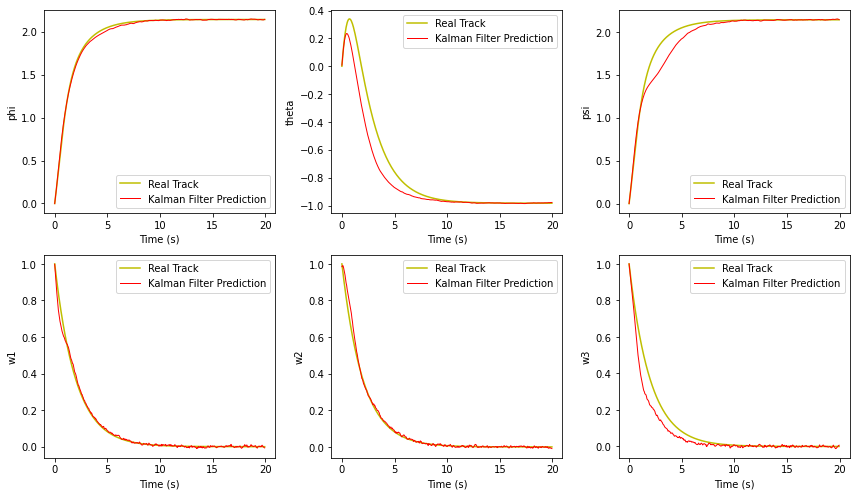

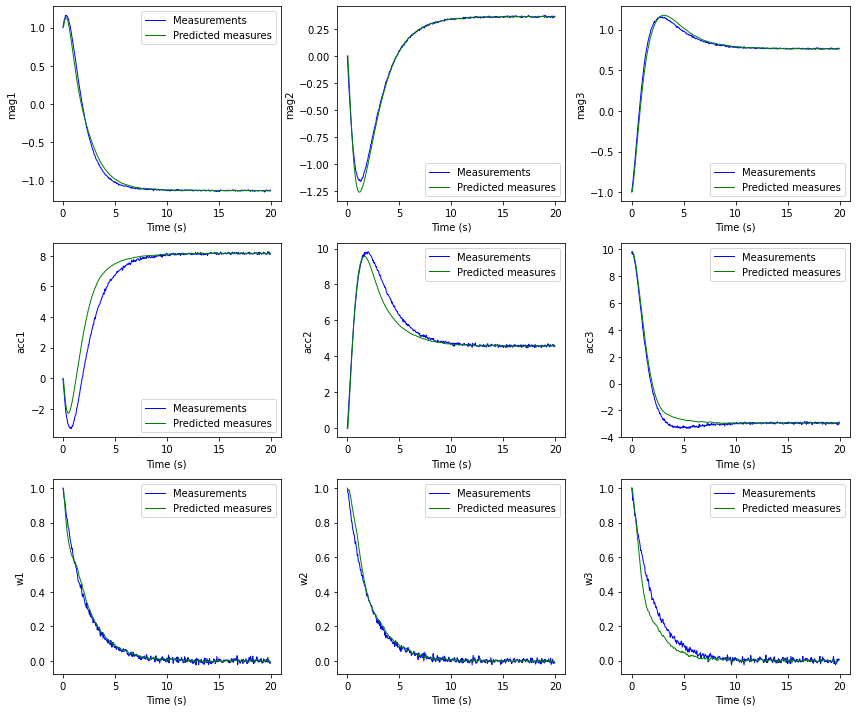

In [23]:
if __name__ == '__main__':
    main()